In [423]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle
import time

In [424]:
df = pd.read_csv('ApartmentRentPrediction_Milestone2.csv')

df.describe()

,id,bathrooms,bedrooms,square_feet,latitude,longitude,time
count,9.000000e+03,8970.000000,8993.000000,9000.000000,8993.00000,8993.000000,9.000000e+03
mean,5.623668e+09,1.380769,1.744023,947.138667,37.67689,-94.778612,1.574906e+09
std,7.007402e+07,0.616171,0.942446,668.806214,5.51527,15.769232,3.755142e+06
min,5.508654e+09,1.000000,0.000000,106.000000,21.31550,-158.022100,1.568744e+09
25%,5.509250e+09,1.000000,1.000000,650.000000,33.66200,-101.858700,1.568781e+09
50%,5.668610e+09,1.000000,2.000000,802.000000,38.75550,-93.707700,1.577358e+09
75%,5.668626e+09,2.000000,2.000000,1100.000000,41.34980,-82.446800,1.577359e+09
max,5.668663e+09,8.500000,9.000000,40000.000000,61.59400,-70.191600,1.577362e+09


In [425]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            9000 non-null   int64  
 1   category      9000 non-null   object 
 2   title         9000 non-null   object 
 3   body          9000 non-null   object 
 4   amenities     5815 non-null   object 
 5   bathrooms     8970 non-null   float64
 6   bedrooms      8993 non-null   float64
 7   currency      9000 non-null   object 
 8   fee           9000 non-null   object 
 9   has_photo     9000 non-null   object 
 10  pets_allowed  5249 non-null   object 
 11  RentCategory  9000 non-null   object 
 12  price_type    9000 non-null   object 
 13  square_feet   9000 non-null   int64  
 14  address       6029 non-null   object 
 15  cityname      8934 non-null   object 
 16  state         8934 non-null   object 
 17  latitude      8993 non-null   float64
 18  longitude     8993 non-null 

# Preprocessing

In [426]:
df.dropna(subset=['longitude','latitude', 'state','cityname','bedrooms','bathrooms'], inplace=True)

pets_allowed_mvalue = df['pets_allowed'].mode()[0]

df['pets_allowed'].fillna(pets_allowed_mvalue, inplace=True)

df['address'] = df.apply(lambda row: row['cityname'] if pd.isnull(row['address']) else row['address'], axis=1)
####################################


df.isnull().sum()

id                 0
category           0
title              0
body               0
amenities       3114
bathrooms          0
bedrooms           0
currency           0
fee                0
has_photo          0
pets_allowed       0
RentCategory       0
price_type         0
square_feet        0
address            0
cityname           0
state              0
latitude           0
longitude          0
source             0
time               0
dtype: int64

In [427]:
len(df['address'].unique())

6577

In [428]:
for i, row in df.iterrows():
  if row['RentCategory'] == 'Low Rent':
    df.at[i, 'RentCategory'] = 1

  elif row['RentCategory'] == 'Medium-Priced Rent':
    df.at[i, 'RentCategory'] = 2

  elif row['RentCategory'] == 'High Rent':
    df.at[i, 'RentCategory'] = 3

  else:
    df.at[i, 'RentCategory'] = 4

df

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,RentCategory,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...","Clubhouse,Fireplace,Gym,Patio/Deck,Playground,...",2.5,2.0,USD,No,Thumbnail,...,2,Monthly,800,Cary,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,"Cable or Satellite,Dishwasher,Elevator,Garbage...",1.0,1.0,USD,No,Thumbnail,...,2,Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...","Basketball,Cable or Satellite,Dishwasher,Inter...",1.0,1.0,USD,No,Thumbnail,...,2,Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921
3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",NaN,1.0,1.0,USD,No,Thumbnail,...,1,Monthly,600,534-542 Park Ave,Omaha,NE,41.2562,-96.0404,RentLingo,1577359849
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",NaN,3.0,3.0,USD,No,Thumbnail,...,3,Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5509251724,housing/rent/apartment,Prominence Apartments Two BR Luxury Apartment ...,Price from: 1158. Your hunt for apartments to ...,"Clubhouse,Gym,Patio/Deck,Pool",1.0,2.0,USD,No,Thumbnail,...,2,Monthly,875,New London,New London,CT,41.3498,-72.1062,RentDigs.com,1568781008
8996,5668612787,housing/rent/apartment,One BR 10001 Ne 1st St,"This unit is located at 10001 Ne first St, Bel...",NaN,1.0,1.0,USD,No,Thumbnail,...,3,Monthly,824,10001 NE 1st St,Bellevue,WA,47.5988,-122.1507,RentLingo,1577358501
8997,5668617853,housing/rent/apartment,Two BR 95 E 2nd St,"This unit is located at 95 E second St, Fond D...","Parking,Storage",1.0,2.0,USD,No,Thumbnail,...,1,Monthly,844,95 E 2nd St,Fond Du Lac,WI,43.7815,-88.4411,RentLingo,1577358818
8998,5509093066,housing/rent/apartment,Pico Rivera - superb Apartment nearby fine din...,Top Rated by Yelp and 5 yrs in a Row! Style an...,"AC,Clubhouse,Dishwasher,Gated,Gym,Internet Acc...",1.0,2.0,USD,No,Thumbnail,...,2,Monthly,489,Pico Rivera,Pico Rivera,CA,33.9883,-118.0875,RentDigs.com,1568772954


In [429]:
# Input string containing substrings separated by commas
input_string = df['amenities']
substring_set = dict()
for value in input_string:
  if type(value) != str:
    continue
  substrings = value.split(',')
  for j in substrings:
    substring_set[j] = [0, 0]

substring_set

{'Clubhouse': [0, 0],
 'Fireplace': [0, 0],
 'Gym': [0, 0],
 'Patio/Deck': [0, 0],
 'Playground': [0, 0],
 'Pool': [0, 0],
 'Cable or Satellite': [0, 0],
 'Dishwasher': [0, 0],
 'Elevator': [0, 0],
 'Garbage Disposal': [0, 0],
 'Internet Access': [0, 0],
 'Parking': [0, 0],
 'Refrigerator': [0, 0],
 'Storage': [0, 0],
 'Basketball': [0, 0],
 'Tennis': [0, 0],
 'Wood Floors': [0, 0],
 'Gated': [0, 0],
 'TV': [0, 0],
 'AC': [0, 0],
 'Doorman': [0, 0],
 'View': [0, 0],
 'Washer Dryer': [0, 0],
 'Luxury': [0, 0],
 'Hot Tub': [0, 0],
 'Alarm': [0, 0],
 'Golf': [0, 0]}

In [430]:
for i in range(df.shape[0]):
  # print(df.iloc[i, 4], i)
  if type(df.iloc[i, 4]) != str:
    continue
  s = df.iloc[i, 4].split(',')
  for j in s:
    substring_set[j][0] += df.iloc[i, 11]
    substring_set[j][1] += 1

l = []

for key, value in substring_set.items():
  l.append((value[0]/value[1], key))

l.sort()
for i in range(len(l)):
  substring_set[l[i][1]] = i

for i in range(df.shape[0]):
  if type(df.iloc[i, 4]) != str:
    df.iloc[i, 4] = 0
    continue
  s = df.iloc[i, 4].split(',')
  tmp = 0
  for j in s:
    tmp += (1 << (substring_set[j]))
  df.iloc[i, 4] = tmp

df.head(20)

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,RentCategory,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5508832632,housing/rent/apartment,"Two BR - $1,194/mo - Apartment - come and see ...","Come experience. in Cary, NC offering recently...",1058562,2.5,2.0,USD,No,Thumbnail,...,2,Monthly,800,Cary,Cary,NC,35.7585,-78.7783,RentDigs.com,1568755960
1,5664576849,housing/rent/apartment,One BR 640 West Wilson Street,This unit is located at 640 West Wilson Street...,4200937,1.0,1.0,USD,No,Thumbnail,...,2,Monthly,795,640 West Wilson St,Madison,WI,43.0724,-89.4003,RentLingo,1577015508
2,5668619365,housing/rent/apartment,One BR 2777 Sw Archer Rd,"This unit is located at 2777 Sw Archer Rd, Gai...",508,1.0,1.0,USD,No,Thumbnail,...,2,Monthly,560,2777 SW Archer Road,Gainesville,FL,29.6533,-82.3656,RentLingo,1577358921
3,5668632604,housing/rent/apartment,One BR 534-542 Park Avenue,"This unit is located at 534-542 Park Avenue, O...",0,1.0,1.0,USD,No,Thumbnail,...,1,Monthly,600,534-542 Park Ave,Omaha,NE,41.2562,-96.0404,RentLingo,1577359849
4,5668637441,housing/rent/apartment,Three BR 2216 S Palm Grove Ave,"This unit is located at 2216 S Palm Grove Ave,...",0,3.0,3.0,USD,No,Thumbnail,...,3,Monthly,1600,2216 S Palm Grove Avenue,Los Angeles,CA,34.0372,-118.2972,RentLingo,1577360159
5,5664597879,housing/rent/apartment,Three BR 680 Bromley Dr.,"This unit is located at 680 Bromley Dr., Baton...",0,2.0,3.0,USD,No,Thumbnail,...,2,Monthly,2300,680 Bromley Drive,Baton Rouge,LA,30.4415,-91.1012,RentLingo,1577017123
6,5509268702,housing/rent/apartment,Studio in Lynnwood,We believe that elevating where you live is al...,1049600,1.0,2.0,USD,No,Yes,...,3,Monthly,1079,Lynnwood,Lynnwood,WA,47.8616,-122.2729,RentDigs.com,1568782110
7,5664594606,housing/rent/apartment,Three BR 1712 Donald Dr,"This unit is located at 1712 Donald Dr, Shawne...",0,2.0,3.0,USD,No,Thumbnail,...,2,Monthly,1177,1712 Donald Drive,Shawnee,OK,35.3537,-96.8923,RentLingo,1577016836
8,5668628991,housing/rent/apartment,One BR 2975 Blackburn St Apartment 678,This unit is located at 2975 Blackburn St Apar...,0,1.0,1.0,USD,No,Thumbnail,...,2,Monthly,678,2975 Blackburn St Apartment 678,Dallas,TX,32.8212,-96.7853,RentLingo,1577359585
9,5668609854,housing/rent/apartment,Two BR 290 9th Ave Sw,"This unit is located at 290 ninth Ave Sw, Fore...",4200938,1.0,2.0,USD,No,Thumbnail,...,2,Monthly,995,290 9th Avenue SW,Forest Lake,MN,45.2764,-92.9901,RentLingo,1577358292


In [431]:
# Apply ceil function

df['bathrooms'] = df['bathrooms'].apply(np.ceil)
df['bedrooms'] = df['bedrooms'].apply(np.ceil)


In [432]:
# Identify numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Detect columns with outliers
columns_with_outliers = []
for column in numeric_columns:
    z_scores = stats.zscore(df[column], nan_policy = 'omit')
    if (z_scores < -3).any():
      columns_with_outliers.append(column)
    elif (z_scores > 3).any():
      columns_with_outliers.append(column)

if columns_with_outliers:
    print("Columns with outliers:", columns_with_outliers)
else:
    print("No columns with outliers detected.")

Columns with outliers: ['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude']


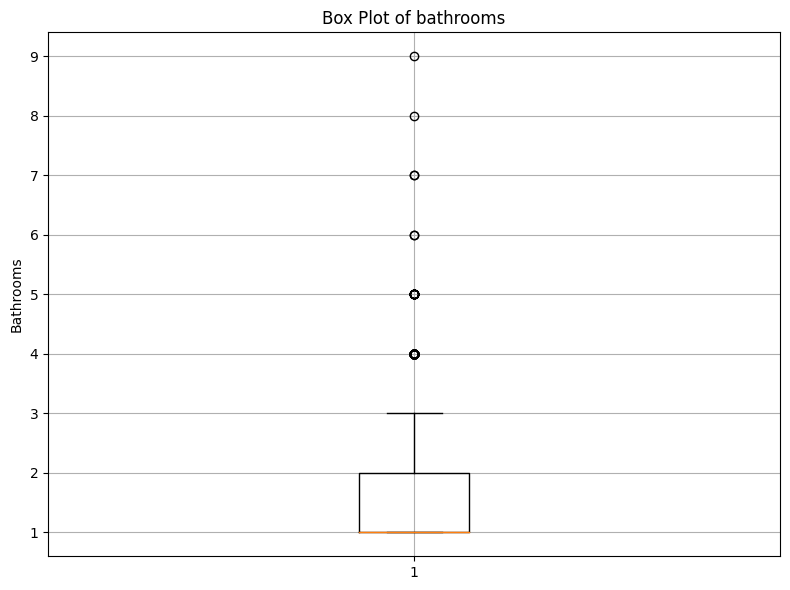

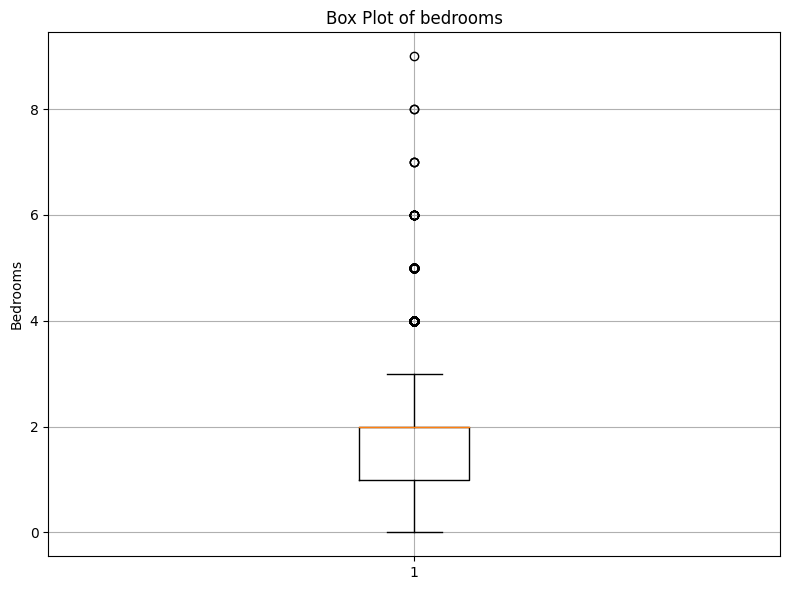

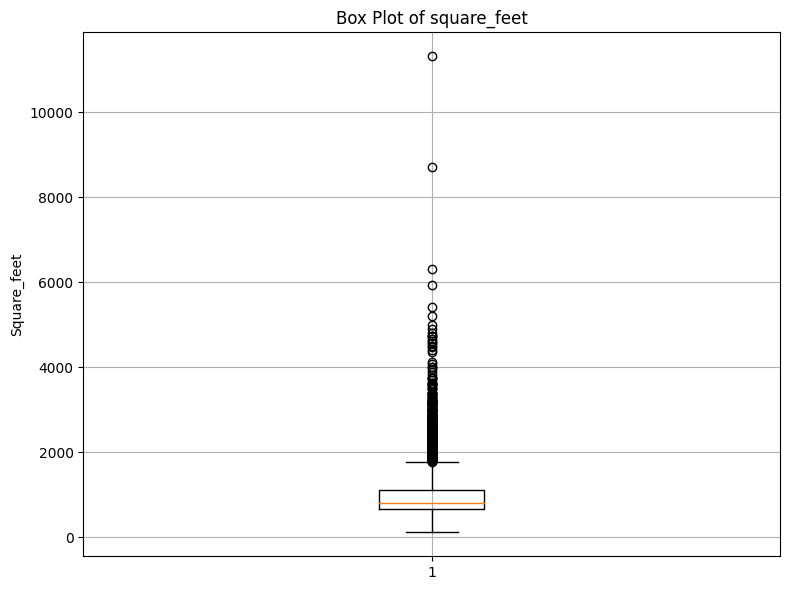

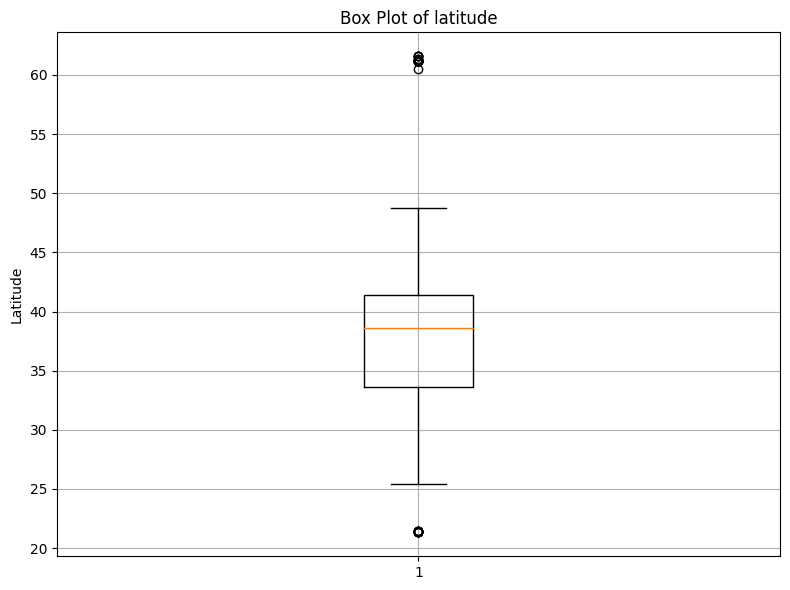

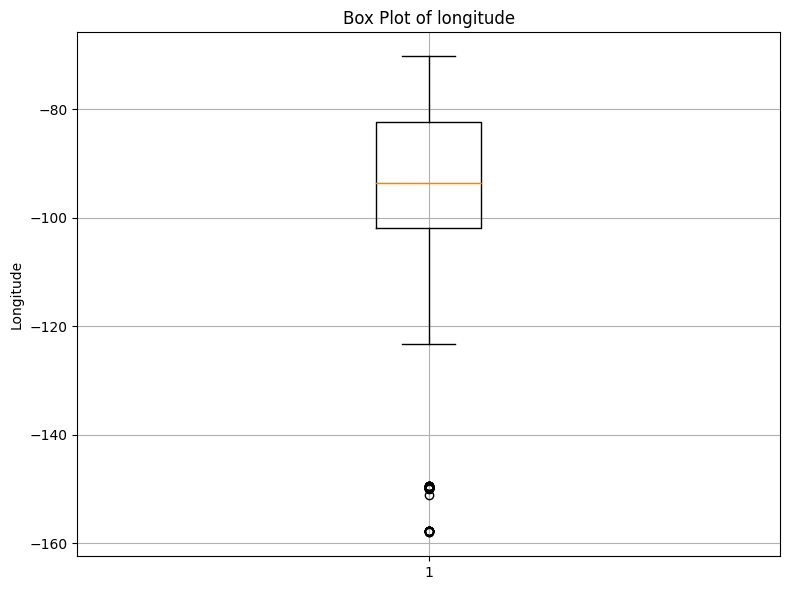

In [433]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['bathrooms'])
plt.title('Box Plot of bathrooms')
plt.ylabel('Bathrooms')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df['bedrooms'])
plt.title('Box Plot of bedrooms')
plt.ylabel('Bedrooms')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df['square_feet'])
plt.title('Box Plot of square_feet')
plt.ylabel('Square_feet')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df['latitude'])
plt.title('Box Plot of latitude')
plt.ylabel('Latitude')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df['longitude'])
plt.title('Box Plot of longitude')
plt.ylabel('Longitude')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [434]:
# Calculate z-scores for each value in the DataFrame
Z = stats.zscore(df.select_dtypes(include=['int64', 'float64']), nan_policy = 'omit')

#Drop outliers with z-score equal to or greater than 3
df.drop(df.index[(np.abs(Z) > 3).any(axis=1)], inplace=True)

print(df.isnull().sum())

id              0
category        0
title           0
body            0
amenities       0
bathrooms       0
bedrooms        0
currency        0
fee             0
has_photo       0
pets_allowed    0
RentCategory    0
price_type      0
square_feet     0
address         0
cityname        0
state           0
latitude        0
longitude       0
source          0
time            0
dtype: int64


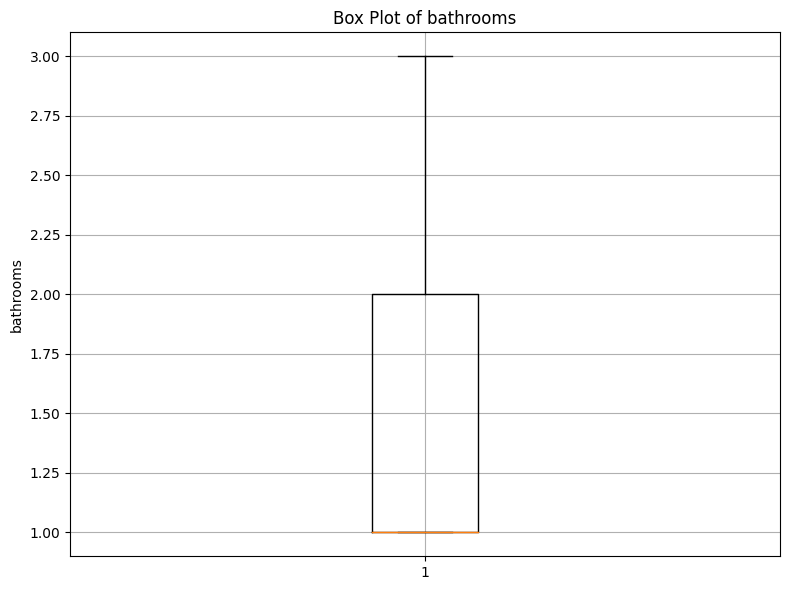

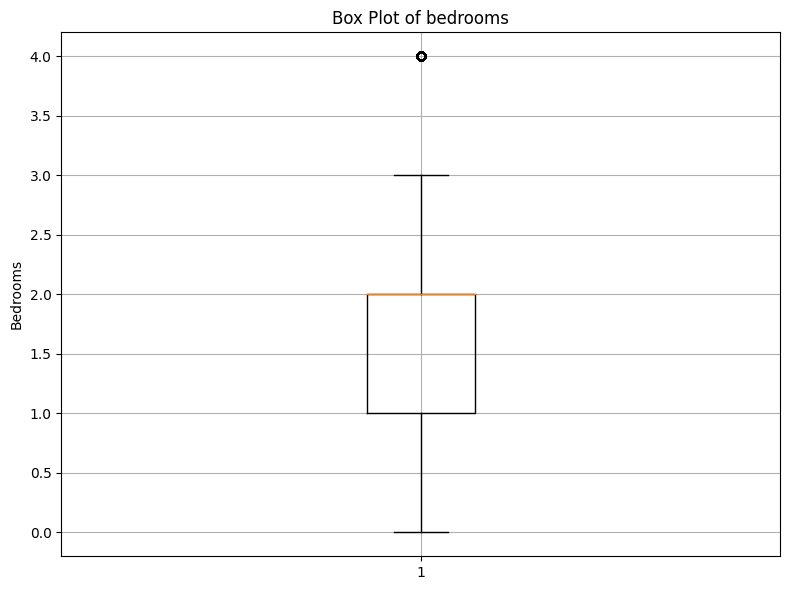

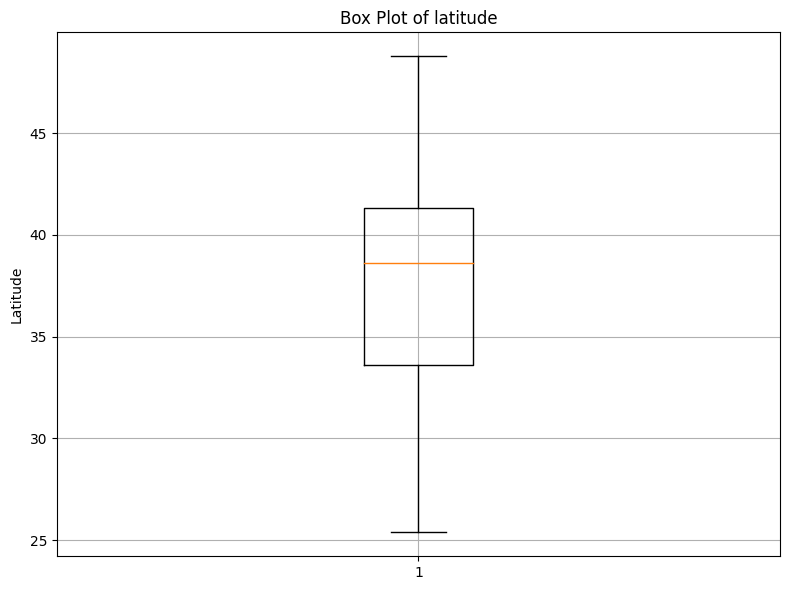

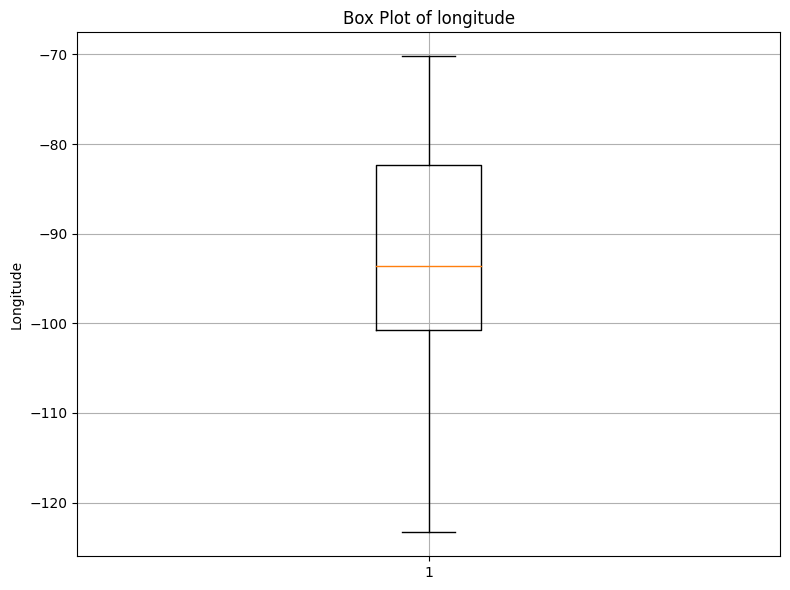

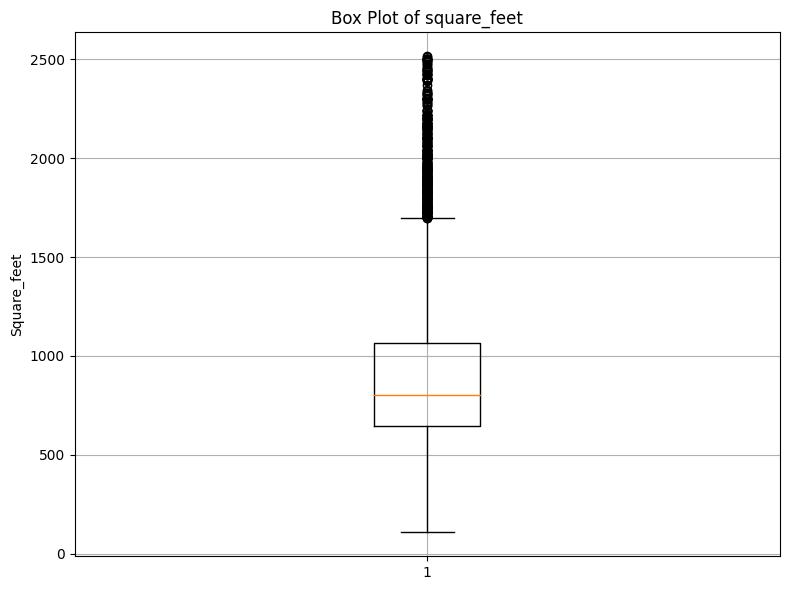

In [435]:
plt.figure(figsize=(8, 6))  # Set the size of the plot
plt.boxplot(df['bathrooms'])
plt.title('Box Plot of bathrooms')
plt.ylabel('bathrooms')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df['bedrooms'])
plt.title('Box Plot of bedrooms')
plt.ylabel('Bedrooms')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df['latitude'])
plt.title('Box Plot of latitude')
plt.ylabel('Latitude')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df['longitude'])
plt.title('Box Plot of longitude')
plt.ylabel('Longitude')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(df['square_feet'])
plt.title('Box Plot of square_feet')
plt.ylabel('Square_feet')
plt.grid(True)  # Add gridlines
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

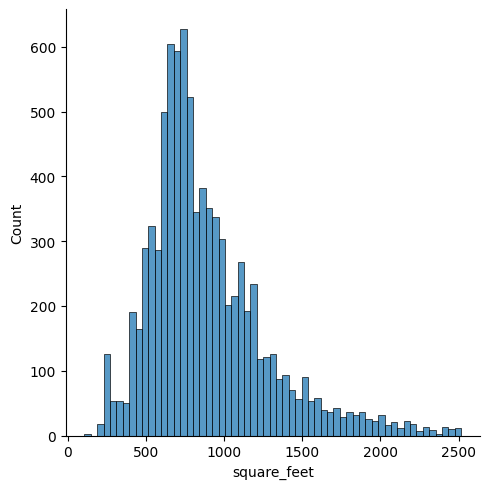

In [436]:
sns.displot(df['square_feet'])

In [437]:
# Encode categorical columns
cat_cols = ['category', 'title', 'body', 'currency', 'fee','has_photo', 'pets_allowed', 'price_type', 'source']
def Feature_Encoder(df,cat_cols):
    for c in cat_cols:
        lbl = LabelEncoder()
        lbl.fit(list(df[c].values))
        df[c] = lbl.transform(list(df[c].values))
    return df

In [438]:
def fet_encod(x, y):
    average_values = x.groupby(y)['RentCategory'].mean()
    sorted_average_values = average_values.sort_values()
    x[y] = x[y].map(sorted_average_values.rank())
    print(sorted_average_values.rank())
    with open(f'{y}_class.pkl', 'wb') as model_file:
      pickle.dump(sorted_average_values, model_file)
fet_encod(df,"cityname")
fet_encod(df,'state')
fet_encod(df,"address")

cityname
Parker            157.0
Clemmons          157.0
Grove             157.0
Cleburne          157.0
Medford Lakes     157.0
                  ...  
Santa Barbara    1384.0
Norwood          1384.0
Florham Park     1384.0
Canonsburg       1384.0
Red Bluff        1384.0
Name: RentCategory, Length: 1444, dtype: float64
state
WY     1.5
WV     1.5
ND     3.0
NE     4.0
IA     5.0
SD     6.0
KY     7.0
MS     8.0
KS     9.0
MO    10.0
IN    11.0
AR    12.0
NM    13.0
LA    14.0
OK    15.0
OH    16.0
AZ    17.0
DE    18.5
MI    18.5
TX    20.0
NC    21.0
WI    22.0
PA    23.0
TN    24.0
UT    25.0
AL    26.0
NV    27.0
ID    28.0
GA    29.0
VT    30.0
SC    31.0
CT    32.0
MN    33.0
FL    34.0
CO    35.0
IL    36.0
VA    37.0
NH    38.0
RI    40.0
MT    40.0
OR    40.0
MD    42.0
NY    43.0
WA    44.0
NJ    45.0
DC    46.0
MA    47.0
CA    48.0
Name: RentCategory, dtype: float64
address
#4 Pahrump Valley Boulevard    1031.0
647 S Main Avenue              1031.0
221 W Wood St            

In [439]:
cityname_mode = df['cityname'].mode()[0]
state_mode = df['state'].mode()[0]
bathrooms_mode = df['bathrooms'].mode()[0]
square_feet_mean = df['square_feet'].mean()

with open('fillna_class.pkl', 'wb') as model_file:
    pickle.dump({'cityname': cityname_mode, 'state':state_mode, 'bathrooms': bathrooms_mode, 'square_feet': square_feet_mean}, model_file)

In [440]:
# Min-Max Scaling on address
df['address'] = (df['address'] - df['address'].min()) / (df['address'].max() - df['address'].min())

In [441]:
#Encoding ID column
tmp = df.copy()
df['id'] = range(1, len(df) + 1)
Feature_Encoder(df,cat_cols)
df.head()

,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,RentCategory,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,1,0,6491,326,1058562,3.0,2.0,0,0,1,...,2,0,800,0.229515,553.5,21.0,35.7585,-78.7783,7,1568755960
1,2,0,3695,6733,4200937,1.0,1.0,0,0,1,...,2,0,795,0.568731,623.0,22.0,43.0724,-89.4003,8,1577015508
2,3,0,2782,4806,508,1.0,1.0,0,0,1,...,2,0,560,0.568731,901.0,34.0,29.6533,-82.3656,8,1577358921
3,4,0,3507,6327,0,1.0,1.0,0,0,1,...,1,0,600,0.000000,350.0,4.0,41.2562,-96.0404,8,1577359849
4,5,0,5943,4325,0,3.0,3.0,0,0,1,...,3,0,1600,1.000000,1313.0,48.0,34.0372,-118.2972,8,1577360159


# Visualizing

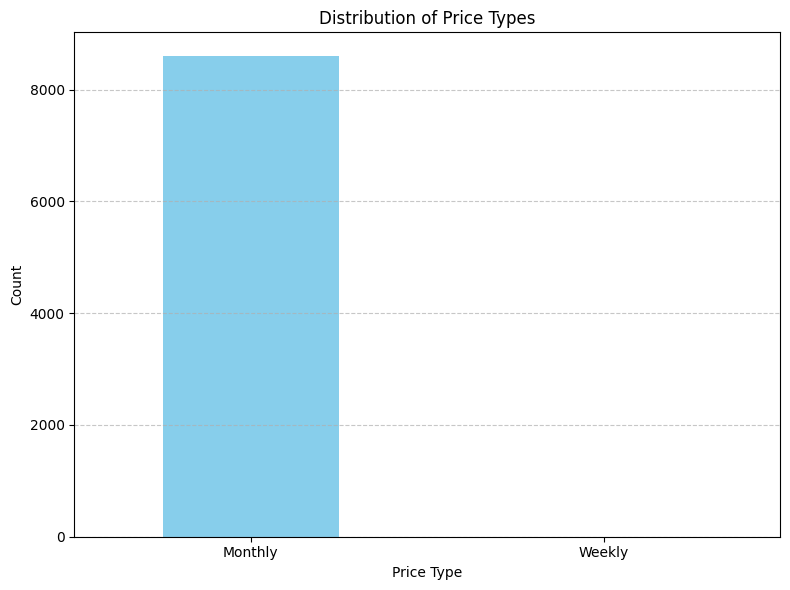

In [442]:
price_type_counts = tmp['price_type'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 6))
price_type_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Price Types')
plt.xlabel('Price Type')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines to the y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

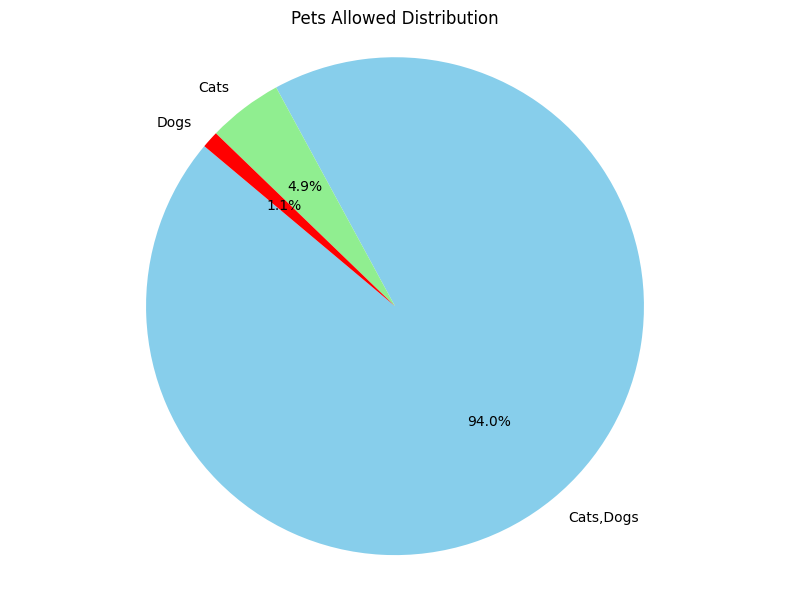

In [443]:
# Count the occurrences of 'Yes' and 'No' in the 'pets_allowed' column
pets_allowed_counts = tmp['pets_allowed'].value_counts()
# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(pets_allowed_counts, labels=pets_allowed_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'red'])
plt.title('Pets Allowed Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

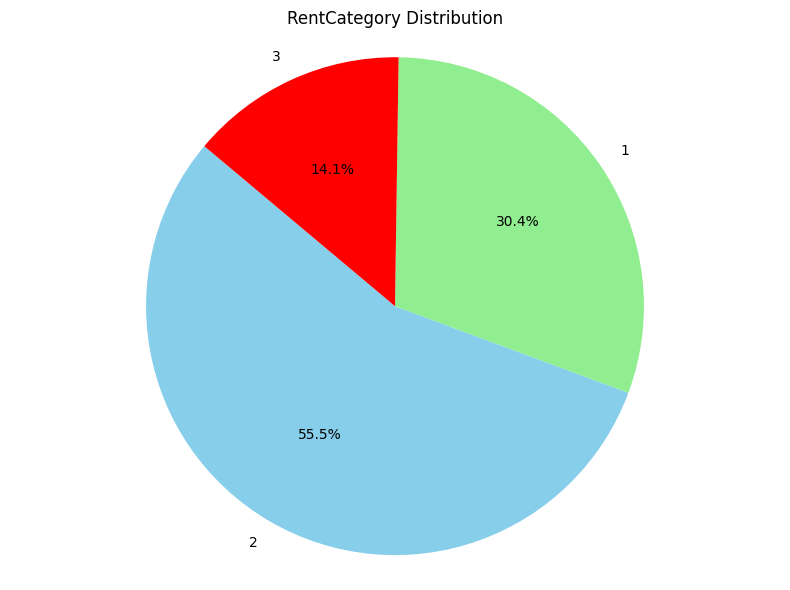

In [444]:
# Count the occurrences of 'Yes' and 'No' in the 'pets_allowed' column
RentCategory_counts = tmp['RentCategory'].value_counts()
# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(RentCategory_counts, labels=RentCategory_counts.index, autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightgreen', 'red'])
plt.title('RentCategory Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

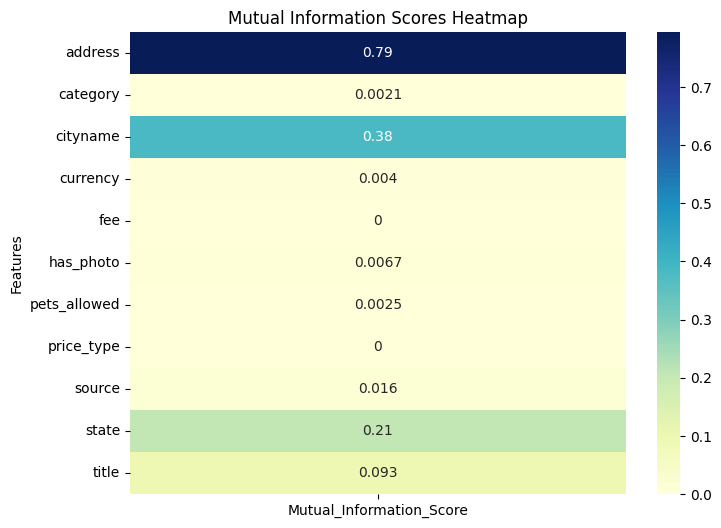

In [445]:
X = df[['cityname', 'address','state', 'pets_allowed', 'has_photo', 'fee', 'currency', 'source', 'price_type', 'title', 'category']]  # Features
y = df['RentCategory'].astype(str)  # Target variable

# Calculate mutual information scores for classification
mi_scores = mutual_info_classif(X, y)

# Create a DataFrame for easier plotting
mi_df = pd.DataFrame({'Features': X.columns, 'Mutual_Information_Score': mi_scores})

# Plotting a heatmap of mutual information scores
plt.figure(figsize=(8, 6))
sns.heatmap(mi_df.pivot_table(index='Features', columns=None, values='Mutual_Information_Score'), annot=True, cmap='YlGnBu')
plt.title('Mutual Information Scores Heatmap')
plt.show()

<ipython-input-446-e08d84f6b978>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ANOVA_F_Value', y='Features', data=anova_df, palette='viridis')


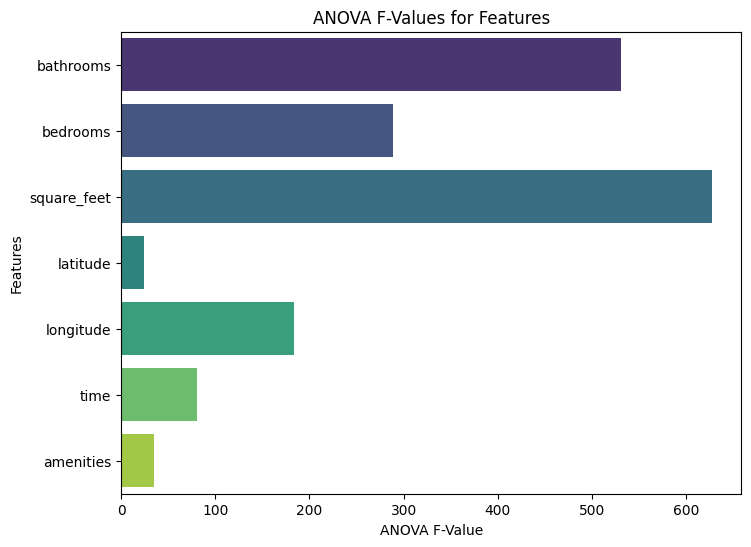

In [446]:
X = df[['bathrooms', 'bedrooms', 'square_feet', 'latitude', 'longitude', 'time', 'amenities']]  # Features
y = df['RentCategory']  # Target variable

# Calculate ANOVA F-values for classification
f_values, p_values = f_classif(X, y)

# Create a DataFrame for easier plotting
anova_df = pd.DataFrame({'Features': X.columns, 'ANOVA_F_Value': f_values})

# Plotting a bar plot of ANOVA F-values
plt.figure(figsize=(8, 6))
sns.barplot(x='ANOVA_F_Value', y='Features', data=anova_df, palette='viridis')
plt.xlabel('ANOVA F-Value')
plt.ylabel('Features')
plt.title('ANOVA F-Values for Features')
plt.show()

In [447]:
df.drop(columns=['address','category', 'title', 'body', 'currency', 'fee','has_photo', 'pets_allowed', 'price_type', 'source', 'latitude', 'longitude', 'id', 'time', 'amenities'], inplace = True)

df.head()

,bathrooms,bedrooms,RentCategory,square_feet,cityname,state
0,3.0,2.0,2,800,553.5,21.0
1,1.0,1.0,2,795,623.0,22.0
2,1.0,1.0,2,560,901.0,34.0
3,1.0,1.0,1,600,350.0,4.0
4,3.0,3.0,3,1600,1313.0,48.0


# **Models**

**SVM**

In [457]:
X = df[['square_feet', 'bathrooms', 'cityname', 'state']]  # Features ###############
y = df['RentCategory'].astype(str)  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Initialize SVM classifier
svm_classifier = SVC(kernel='rbf', gamma=10, probability=True, random_state=42)

# Train the classifier
train_time_start_SVM = time.time()
svm_classifier.fit(X_train, y_train)
train_time_end_SVM = time.time()

train_time_SVM = train_time_end_SVM - train_time_start_SVM

# Make predictions on the test set
test_time_start_SVM = time.time()
y_pred = svm_classifier.predict(X_test)
test_time_end_SVM = time.time()

test_time_SVM = test_time_end_SVM - test_time_start_SVM

y_train_pred = svm_classifier.predict(X_train)

# Evaluate the classifier
accuracySVM = accuracy_score(y_test, y_pred)
accuracy2 = accuracy_score(y_train, y_train_pred)

report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy(train):", accuracy2)
print("Accuracy(test):", accuracySVM)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_mat)

with open('SVM_class.pkl', 'wb') as model_file:
    pickle.dump(svm_classifier, model_file)

Accuracy(train): 0.9784821168944461
Accuracy(test): 0.6162790697674418
Classification Report:
               precision    recall  f1-score   support

           1       0.78      0.19      0.31       513
           2       0.60      0.97      0.74       971
           3       0.95      0.08      0.15       236

    accuracy                           0.62      1720
   macro avg       0.78      0.41      0.40      1720
weighted avg       0.70      0.62      0.53      1720

Confusion Matrix:
 [[ 99 414   0]
 [ 28 942   1]
 [  0 217  19]]


**Decision Tree**

In [449]:

# Initialize decision tree classifier
dt_classifier = DecisionTreeClassifier(
    max_depth=8,
    random_state=42,
    )

# Train the classifier
train_time_start_DT = time.time()
dt_classifier.fit(X_train, y_train)
train_time_end_DT = time.time()

train_time_DT = train_time_end_DT - train_time_start_DT
# Make predictions on the test set
test_time_start_DT = time.time()
y_pred = dt_classifier.predict(X_test)
test_time_end_DT = time.time()

test_time_DT = test_time_end_DT - test_time_start_DT
y_train_pred = dt_classifier.predict(X_train)

# Evaluate the classifier
accuracyDT = accuracy_score(y_test, y_pred)
accuracy2 = accuracy_score(y_train, y_train_pred)

report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy(train):", accuracy2)
print("Accuracy(test):", accuracyDT)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_mat)

Accuracy(train): 0.8326548415236987
Accuracy(test): 0.8040697674418604
Classification Report:
               precision    recall  f1-score   support

           1       0.74      0.81      0.77       513
           2       0.83      0.82      0.83       971
           3       0.87      0.70      0.78       236

    accuracy                           0.80      1720
   macro avg       0.81      0.78      0.79      1720
weighted avg       0.81      0.80      0.80      1720

Confusion Matrix:
 [[417  95   1]
 [147 800  24]
 [  3  67 166]]


**Naive Bayes**

In [450]:
nb_classifier = GaussianNB()

train_time_start_NB = time.time()
nb_classifier.fit(X_train, y_train)
train_time_end_NB = time.time()

train_time_NB = train_time_end_NB - train_time_start_NB
# Make predictions on the test set
test_time_start_NB = time.time()
y_pred = nb_classifier.predict(X_test)
test_time_end_NB = time.time()

test_time_NB = test_time_end_NB - test_time_start_NB

y_train_pred = nb_classifier.predict(X_train)

# Evaluate the classifier
accuracyNB = accuracy_score(y_test, y_pred)
accuracy2 = accuracy_score(y_train, y_train_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy(train):", accuracy2)
print("Accuracy(test):", accuracyNB)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_mat)

Accuracy(train): 0.7118348357080546
Accuracy(test): 0.7186046511627907
Classification Report:
               precision    recall  f1-score   support

           1       0.63      0.83      0.71       513
           2       0.83      0.64      0.72       971
           3       0.65      0.80      0.72       236

    accuracy                           0.72      1720
   macro avg       0.70      0.76      0.72      1720
weighted avg       0.74      0.72      0.72      1720

Confusion Matrix:
 [[424  88   1]
 [248 623 100]
 [  5  42 189]]


**KNN**

In [451]:
knn_classifier = KNeighborsClassifier(n_neighbors=30)

train_time_start_KNN = time.time()
knn_classifier.fit(X_train, y_train)
train_time_end_KNN = time.time()

train_time_KNN = train_time_end_KNN - train_time_start_KNN
# Make predictions on the test set
test_time_start_KNN = time.time()
y_pred = knn_classifier.predict(X_test)
test_time_end_KNN = time.time()

test_time_KNN = test_time_end_KNN - test_time_start_KNN

y_train_pred = nb_classifier.predict(X_train)

# Evaluate the classifier
accuracyKNN = accuracy_score(y_test, y_pred)
accuracy2 = accuracy_score(y_train, y_train_pred)
report = classification_report(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy(train):", accuracy2)
print("Accuracy(test):", accuracyKNN)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", confusion_mat)

Accuracy(train): 0.7118348357080546
Accuracy(test): 0.7965116279069767
Classification Report:
               precision    recall  f1-score   support

           1       0.76      0.76      0.76       513
           2       0.81      0.84      0.82       971
           3       0.82      0.70      0.76       236

    accuracy                           0.80      1720
   macro avg       0.80      0.77      0.78      1720
weighted avg       0.80      0.80      0.80      1720

Confusion Matrix:
 [[388 125   0]
 [118 817  36]
 [  3  68 165]]


**Ensemble Learning(Voting)**

In [452]:
voting_classifier = VotingClassifier(estimators=[('dt', dt_classifier), ('svm', svm_classifier), ('knn', knn_classifier),('nb', nb_classifier)], voting='hard')

# Train the classifier
train_time_start_ELV = time.time()
voting_classifier.fit(X_train, y_train)
train_time_end_ELV = time.time()

train_time_ELV = train_time_end_ELV - train_time_start_ELV
# Make predictions on the test set
test_time_start_ELV = time.time()
y_pred_voting = voting_classifier.predict(X_test)
test_time_end_ELV = time.time()

test_time_ELV = test_time_end_ELV - test_time_start_ELV

y_pred_voting_train = voting_classifier.predict(X_train)

# Evaluate the classifier
accuracy_votingELV = accuracy_score(y_test, y_pred_voting)
accuracy_voting2 = accuracy_score(y_train, y_pred_voting_train)
report_voting = classification_report(y_test, y_pred_voting)
confusion_mat_voting = confusion_matrix(y_test, y_pred_voting)

print("Voting Classifier Accuracy(train):", accuracy_voting2)
print("Voting Classifier Accuracy(test):", accuracy_votingELV)
print("Voting Classifier Classification Report:\n", report_voting)
print("Voting Classifier Confusion Matrix:\n", confusion_mat_voting)

Voting Classifier Accuracy(train): 0.8134632160511777
Voting Classifier Accuracy(test): 0.8
Voting Classifier Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.82      0.78       513
           2       0.83      0.81      0.82       971
           3       0.84      0.71      0.77       236

    accuracy                           0.80      1720
   macro avg       0.80      0.78      0.79      1720
weighted avg       0.80      0.80      0.80      1720

Voting Classifier Confusion Matrix:
 [[423  90   0]
 [153 785  33]
 [  2  66 168]]


**Ensemble Learning(Stacking)**

In [453]:
base_classifiers = [
    dt_classifier,
    svm_classifier,
    knn_classifier,
    nb_classifier
]

meta_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Initialize stacking classifier
stacking_classifier = StackingClassifier(classifiers=base_classifiers,
                                         meta_classifier=meta_classifier,
                                         use_probas=True)

# Train the stacking classifier
train_time_start_ELS = time.time()
stacking_classifier.fit(X_train, y_train)
train_time_end_ELS = time.time()

train_time_ELS = train_time_end_ELS - train_time_start_ELS
# Make predictions on the test set
test_time_start_ELS = time.time()
y_pred_stacking = stacking_classifier.predict(X_test)
test_time_end_ELS = time.time()

test_time_ELS = test_time_end_ELS - test_time_start_ELS

y_pred_stacking_train = stacking_classifier.predict(X_train)
# Evaluate the classifier
accuracy_stackingELS = accuracy_score(y_test, y_pred_stacking)
accuracy_stacking2 = accuracy_score(y_train, y_pred_stacking_train)

print("Stacking Classifier Accuracy(train):", accuracy_stacking2)
print("Stacking Classifier Accuracy(test):", accuracy_stackingELS)

with open('ELSR_class.pkl', 'wb') as model_file:
    pickle.dump(stacking_classifier, model_file)

Stacking Classifier Accuracy(train): 0.8927013666763594
Stacking Classifier Accuracy(test): 0.8116279069767441


# Models Stats

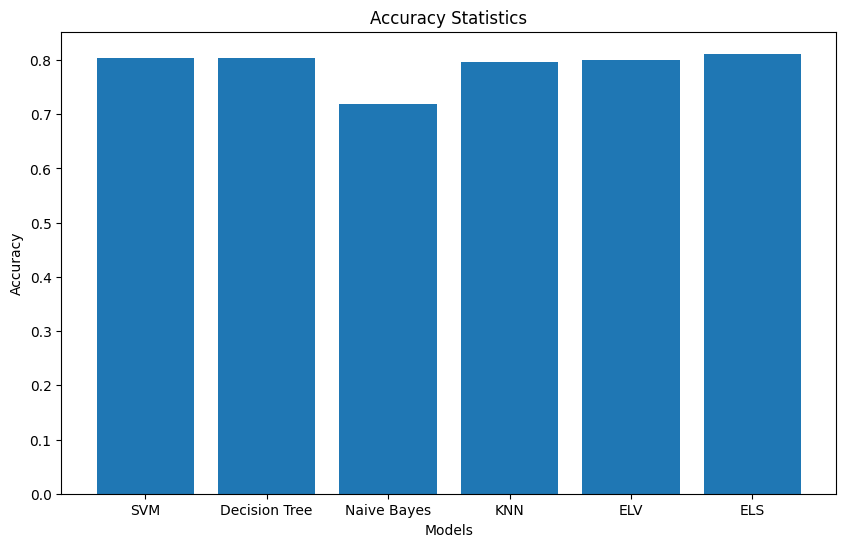

In [454]:
plt.figure(figsize=(10, 6))
categories = ['SVM', 'Decision Tree', 'Naive Bayes', 'KNN', 'ELV', 'ELS']
values = [accuracySVM, accuracyDT, accuracyNB, accuracyKNN, accuracy_votingELV, accuracy_stackingELS]
plt.bar(categories, values)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Statistics')
plt.show()

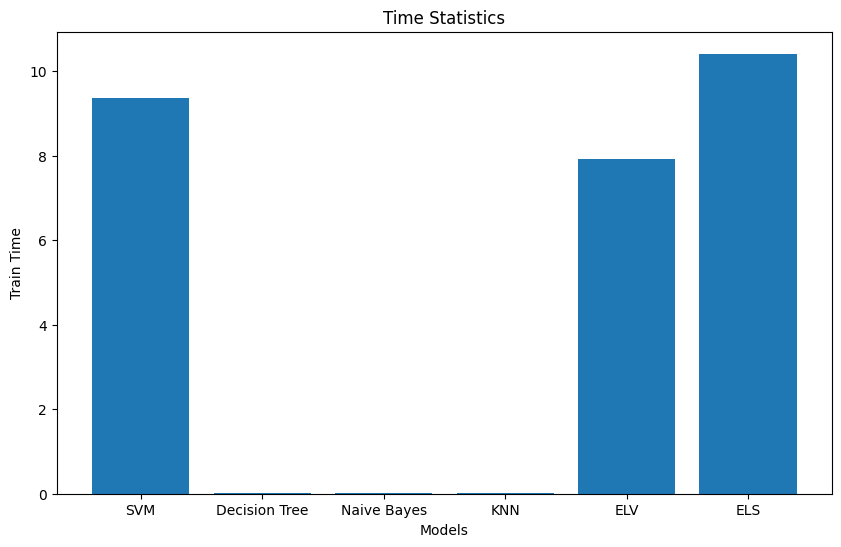

In [455]:
plt.figure(figsize=(10, 6))
categories = ['SVM', 'Decision Tree', 'Naive Bayes', 'KNN', 'ELV', 'ELS']
values = [train_time_SVM, train_time_DT, train_time_NB, train_time_KNN, train_time_ELV, train_time_ELS]
plt.bar(categories, values)
plt.xlabel('Models')
plt.ylabel('Train Time')
plt.title('Time Statistics')
plt.show()

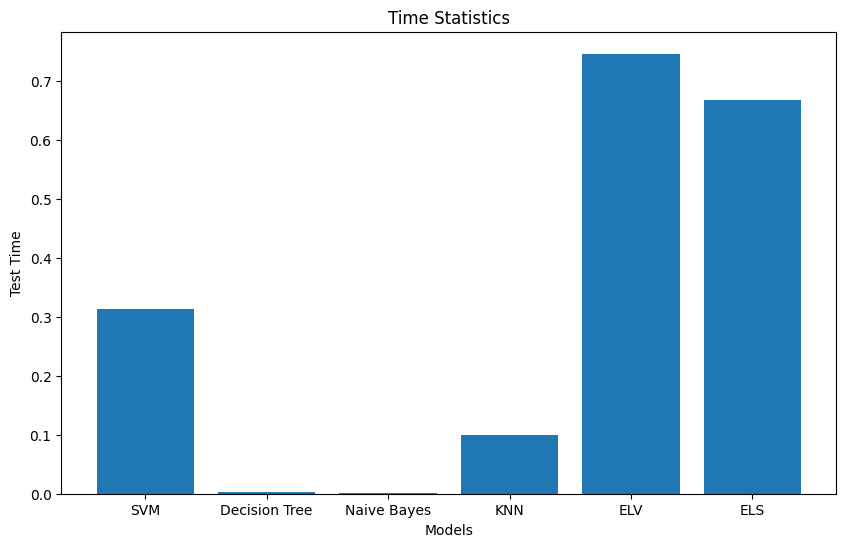

In [456]:
plt.figure(figsize=(10, 6))
categories = ['SVM', 'Decision Tree', 'Naive Bayes', 'KNN', 'ELV', 'ELS']
values = [test_time_SVM, test_time_DT, test_time_NB, test_time_KNN, test_time_ELV, test_time_ELS]
plt.bar(categories, values)
plt.xlabel('Models')
plt.ylabel('Test Time')
plt.title('Time Statistics')
plt.show()